# Importing Dependencies

In [1]:
from torch import nn
import torch
import gym
from collections import deque
import itertools
import numpy as np
import random

# Defining Hyper Parameteres

In [2]:
GAMMA=0.99 #Discount rate
LEARNING_RATE=5e-4 #learning rate 
BATCH_SIZE=32 #Number of samples from repaly buffer
BUFFER_SIZE=50000 #Maximum size before overwritting
MIN_REPLAY_SIZE=1000 #Number of transiotions in replay buffer before computing gradients
EPSILON_START=1.0 #Starting value of eps
EPSILON_END=0.002 #Ending value of eps
EPSILON_DECAY=10000 #Decay value of eps
TARGET_UPDATE_FREQ=1000 #Number of steps of target update

# Creating Environment

In [3]:
env =gym.make("CartPole-v0")

### Inderstanding the Environment

In [4]:
print('Action_space: ',env.action_space,"\n")
print('Number of actions: ', env.action_space.n,"\n")
print('Action_space sample:',env.action_space.sample(),"\n")
print('Observation_space: ',env.observation_space,"\n")
print('State shape: ', env.observation_space.shape,"\n")
print('Observation_space sample:',env.observation_space.sample(),"\n")


Action_space:  Discrete(2) 

Number of actions:  2 

Action_space sample: 0 

Observation_space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32) 

State shape:  (4,) 

Observation_space sample: [-2.0469534e+00 -2.4417427e+38 -2.6461276e-01  1.1647263e+38] 



### Testing Untrained Agent

In [5]:
episodes=5
for episode in range(1,episodes+1):
    state=env.reset()
    done=False
    score=0
    
    while not done:
        env.render()
        action=env.action_space.sample()
        n_state,reward,done,info=env.step(action)
        score+=reward
    print("episode:{} score:{}".format(episode,score))

episode:1 score:13.0
episode:2 score:39.0
episode:3 score:55.0
episode:4 score:48.0
episode:5 score:23.0


In [6]:
env.close()

# Training an agent using DQN Algorithm

In [7]:
replay_buffer=deque(maxlen=BUFFER_SIZE) #creating replay buffer
rew_buffer=deque([0,0],maxlen=100) #To store the rewards earned in a single episode
episode_reward=0.0

### Creating Network Class

In [8]:
class Network(nn.Module):
    def __init__(self,env):
        super().__init__()
        
        in_features=int(np.prod(env.observation_space.shape))
        self.net=nn.Sequential(
           nn.Linear(in_features,64),
           nn.Tanh(),
           nn.Linear(64,env.action_space.n))
    def forward(self,x):
        return self.net(x)
    def act(self,obs):
        obs_t=torch.as_tensor(obs,dtype=torch.float32)
        q_values=self(obs_t.unsqueeze(0))
        max_q_index=torch.argmax(q_values,dim=1)[0]
        action=max_q_index.detach().item()
        
        return action 
    

### Creating Network

In [9]:
online_net=Network(env)
target_net=Network(env)
target_net.load_state_dict(online_net.state_dict())
#create optimizer
optimizer=torch.optim.Adam(online_net.parameters(),lr=LEARNING_RATE)

### Initilizing Replay Buffer

In [10]:
obs=env.reset() #reset environmet
for _ in range(MIN_REPLAY_SIZE):
    action=env.action_space.sample()
    
    new_obs,rew,done,_=env.step(action)
    transition=(obs,action,rew,done,new_obs)
    replay_buffer.append(transition)
    obs=new_obs
    if done:
        obs=env.reset()
        

### Training loop

In [11]:
obs = env.reset()
scores=[]
for step in itertools.count():
    epsilon=np.interp(step,[0,EPSILON_DECAY],[EPSILON_START,EPSILON_END])
    
    rnd_sample=random.random()
    if rnd_sample <= epsilon:
        action=env.action_space.sample()
    else:
        action=online_net.act(obs)
    new_obs,rew,done,_=env.step(action)
    transition=(obs,action,rew,done,new_obs)
    replay_buffer.append(transition)
    obs=new_obs
    
    episode_reward+=rew
    
    if done:
        obs=env.reset()
        
        rew_buffer.append(episode_reward)
        episode_reward=0.0
    
        
    # Start Gradient Step
    transitions=random.sample(replay_buffer,BATCH_SIZE)
    
    obses=np.asarray([t[0] for t in transitions])
    actions=np.asarray([t[1]for t in transitions])
    rews=np.asarray([t[2]for t in transitions])
    dones=np.asarray([t[3]for t in transitions])
    new_obses=np.asarray([t[4] for t in transitions])
    
    obses_t = torch.as_tensor(obses,dtype=torch.float32)
    actions_t = torch.as_tensor(actions,dtype=torch.int64).unsqueeze(-1)
    rews_t = torch.as_tensor(rews,dtype=torch.float32).unsqueeze(-1)
    dones_t = torch.as_tensor(dones,dtype=torch.float32).unsqueeze(-1)
    new_obses_t = torch.as_tensor(new_obses,dtype=torch.float32)
    
    #Compute Targets
    target_q_values=target_net(new_obses_t)
    max_target_q_values=target_q_values.max(dim=1,keepdim=True)[0]
    
    targets=rews_t+GAMMA*(1-dones_t)*max_target_q_values
    
    #compute loss
    q_values=online_net(obses_t)
    
    action_q_values=torch.gather(input=q_values,dim=1,index=actions_t)
    
    loss=nn.functional.smooth_l1_loss(action_q_values,targets)
    
    #gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #update target network
    if step % TARGET_UPDATE_FREQ==0:
        target_net.load_state_dict(online_net.state_dict())
        
    #logging
    if step%1000==0:
        print('step',step)
        print('avg rew',np.mean(rew_buffer))
        scores.append(np.mean(rew_buffer))
    if (np.mean(rew_buffer)>=200):
        break   
        

step 0
avg rew 0.0
step 1000
avg rew 19.62
step 2000
avg rew 21.180851063829788
step 3000
avg rew 23.55
step 4000
avg rew 28.04
step 5000
avg rew 33.73
step 6000
avg rew 42.13
step 7000
avg rew 49.86
step 8000
avg rew 57.24
step 9000
avg rew 66.8
step 10000
avg rew 75.62
step 11000
avg rew 84.29
step 12000
avg rew 92.77
step 13000
avg rew 101.34
step 14000
avg rew 109.89
step 15000
avg rew 117.99
step 16000
avg rew 126.35
step 17000
avg rew 134.57
step 18000
avg rew 142.22
step 19000
avg rew 149.75
step 20000
avg rew 157.59
step 21000
avg rew 165.84
step 22000
avg rew 172.54
step 23000
avg rew 177.56
step 24000
avg rew 182.84
step 25000
avg rew 187.67
step 26000
avg rew 191.27
step 27000
avg rew 195.45
step 28000
avg rew 198.08
step 29000
avg rew 198.39
step 30000
avg rew 198.04
step 31000
avg rew 197.63
step 32000
avg rew 196.92
step 33000
avg rew 196.03
step 34000
avg rew 194.02
step 35000
avg rew 192.31
step 36000
avg rew 190.98
step 37000
avg rew 189.02
step 38000
avg rew 186.58
st

# Testing the trained Agent

In [12]:
episodes=5
for episode in range(1,episodes+1):
    obs=env.reset()
    done=False
    score=0
    
    while not done:
        env.render()
        action=online_net.act(obs)
        obs,reward,done,info=env.step(action)
        score+=reward
    print("episode:{} score:{}".format(episode,score))

episode:1 score:200.0
episode:2 score:200.0
episode:3 score:200.0
episode:4 score:200.0
episode:5 score:200.0


In [13]:
env.close()

# Plotting Results

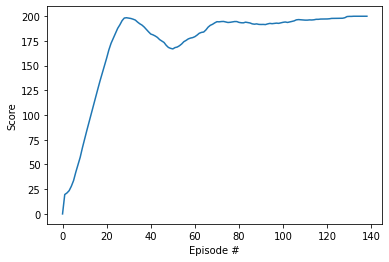

In [14]:
# plot the scores
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()